# Annotation Game
In this game, participants are required to annotate data according to some ___target concept___ in `T` rounds.

<img src="imgs/task illustration.png" width = "200" align=left />

Each round consists of two phases:  
__Test__:  
    _The participant will be required to annotate `K` instances from the dataset._  
__Teaching__:   
    _`M` annotation examples from experts will be show to the participant._  
    
Every participant will be paid \$0.01 for the first round, and get ___performance-contingent bonus___ \$0.02 each round after. 

### Please do as well as you can!
We will qualify you for bouns in the test phase, and suggest you some expert labels for help in the teaching phase.  
The bouns is given accordingly to your __relative performance__ (a.k.a improvement) rather than your absolute performance (a.k.a. accuracy).  
Therefore, the best way to maximize your gains is to do the best in each round! __You would earn as much as experts do!__

--------
## Task 1:  "ピンク"
Please annotate all the "ピンク" instances with "1" and others with "0".

<img src="imgs/task illustration 2.png" width = "320" align=left />

Features $x = (f_1, f_2, f_3)$:  
- `Shape` $[f_1]$: `1` = `triangle`, `0` = `circle`. 
- `Border` $[f_2]$: `1` = `real border`, `0` = `dotted border`.
- `Color` $[f_3]$: `1` = `pink`, `0` = `bule`.

Hypothesis Space $\mathcal H = \{h_1, h_1', h_2, h_2', h_3, h_3'\}$
-  $h_1(x) = f_1$ (`ピンク is triangle`) and $h_1'(x) = 1 - f_1$ (`ピンク is circle`)
- $h_2(x) = f_2$ (`ピンク is real`) and $h_1'(x) = 1 - f_2$ (`ピンク is dotted`)
- $h_3(x) = f_3$ (`ピンク is pink`) and $h_1'(x) = 1 - f_3$ (`ピンク is bule`)

In [1]:
import numpy as np
from sklearn.preprocessing import normalize
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='ticks', palette='Set2')
%matplotlib inline
K = 10 # K instances per round in the test phase
M = 2 # M teaching examples per round in the teaching phase

# Hypothesis Space {h1, ..., h3'}
def hypothesis(x, i):
    switcher = {
        0: lambda t: t[0],     # h1:  triangle
        1: lambda t: 1 - t[0], # h1': circle
        2: lambda t: t[1],     # h2:  real
        3: lambda t: 1 - t[1], # h2': dotted
        4: lambda t: t[2],     # h3:  pink
        5: lambda t: 1 - t[2]  # h3': bule
    }
    return switcher.get(i)(x)

# Initialize Annotator Belief: 
def l1normalize(v):
    norm = np.linalg.norm(v, ord=1)
    if norm == 0: return v
    else: return v / norm

rho = l1normalize(np.random.rand(6))
rho = np.array([0.25,0,0.25,0,0.5,0])

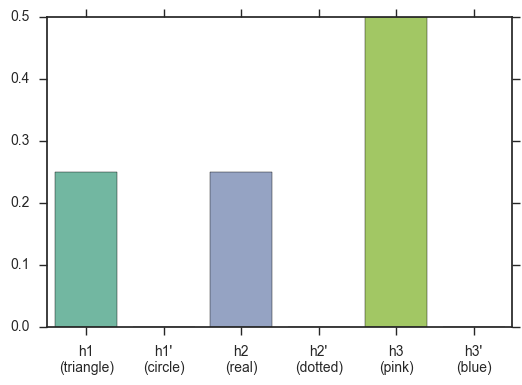

In [2]:
# visualize the initial belief
hyps = ["h1\n(triangle)","h1'\n(circle)","h2\n(real)",
        "h2'\n(dotted)","h3\n(pink)","h3'\n(blue)"]
sns.barplot(x="hypothesis", y="confidence", 
            data= {
                "hypothesis":hyps, 
                "confidence":rho});

-----
### Round 1 - Test Phase

In [3]:
# First Round - Test Phase
# Sample K instance from the dataset uniform randomly
questions = np.random.choice(2, (K, 3))
# Pick hypothesis and label the data according to current belief
actions = np.random.choice(range(6), size=K, p=rho)
answers = np.array([hypothesis(questions[i], actions[i]) for i in xrange(K)])

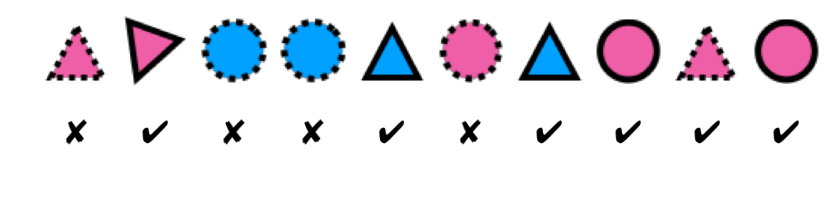

In [4]:
# Visualize the answers
_, ax = plt.subplots(2, K, figsize=(K, 2));
for i in xrange(K):
    name = ""
    ansname = ""
    for j in xrange(3):
        name += str(questions[i,j])
    ansname = str(answers[i])
    img = mpimg.imread("imgs/"+ name +".png")
    ans = mpimg.imread("imgs/"+ ansname +".png")
    ax[0, i].imshow(img); ax[0, i].axis('off');
    ax[1, i].imshow(ans); ax[1, i].axis('off');

#### Belief Estimation
The parameterized belief (multinoulli distribution): $\displaystyle {\rho}_{\theta}(h_i) = \frac{e^{\theta_{h_i}}}{\sum_{h\in\mathcal H}e^{\theta_{h}}}$.  
The belief estimation $\rho_{\widehat\theta}$ is updated by minimizing $\mathcal L(\theta) = \displaystyle \|\rho_\theta - \rho\| - H(\rho_{\theta})$, where $\displaystyle \|\rho_{\theta} - \rho\| := \mathbb E_{h\sim \rho_{\theta}}\left[ \sum_{i=1}^{K} \left|h(x_i) - y_i\right|\right]$.  
Its gredient:  
$\begin{eqnarray}
\displaystyle \nabla_{\theta} \mathcal L(\theta) & = & \nabla_{\theta} \left( \mathbb E_{h\sim \rho_{\theta}}\left[ \sum_{i=1}^{K} \left|h(x_i) - y_i\right|\right] - H(\rho_{\theta}) \right) \\
& = & \nabla_{\theta} \sum_{i=1}^{K}\left[ \mathbb E_{h\sim \rho_{\theta}}  \left|h(x_i) - y_i\right|\right] - \nabla_{\theta} \sum_{h\in \mathcal H} -\rho_{\theta}(h)\log(\rho_{\theta}(h))\\
& = & \nabla_{\theta} \sum_{i=1}^{K}\left[ \sum_{h\in\mathcal H} \rho_{\theta}(h) \left|h(x_i) - y_i\right|\right] +  \sum_{h\in \mathcal H} \nabla_{\theta} \rho_{\theta}(h)\log(\rho_{\theta}(h))\\
& = &\sum_{i=1}^{K}\left\{ \sum_{h\in\mathcal H} \frac{ \nabla_{\theta} \rho_{\theta}(h)}{\rho_{\theta}(h)} \rho_{\theta}(h) \left|h(x_i) - y_i\right|\right\} +  \sum_{h\in \mathcal H} \left\{\log(\rho_{\theta}(h)) \nabla_{\theta} \rho_{\theta}(h) + \rho_{\theta}(h) \nabla_{\theta}\log(\rho_{\theta}(h)) \right\}\\
& = &\sum_{i=1}^{K}\left\{\mathbb E_{h\sim \rho_{\theta}} \left[\left|h(x_i) - y_i\right| \cdot \nabla_{\theta}\log(\rho_{\theta}(h))\right] \right\} +  \sum_{h\in \mathcal H} \left\{(\log(\rho_{\theta}(h))  + 1) \cdot \frac{\nabla_{\theta} \rho_{\theta}(h)}{\rho_{\theta}(h)}\rho_{\theta}(h) \right\}\\
& = &\sum_{i=1}^{K}\left\{\mathbb E_{h\sim \rho_{\theta}} \left[\left|h(x_i) - y_i\right| \cdot
\nabla_{\theta}\log(\rho_{\theta}(h))\right] +  \frac{1}{K}\cdot\mathbb E_{h\sim \rho_{\theta}} \left[(\log(\rho_{\theta}(h))  + 1) \cdot \nabla_{\theta} \log(\rho_{\theta}(h)) \right] \right\}\\
& = &\sum_{i=1}^{K}\left\{\mathbb E_{h\sim \rho_{\theta}}\left[ \left(\left|h(x_i) - y_i\right|+\frac{1}{K}(\log(\rho_{\theta}(h))  + 1)\right) \cdot
\nabla_{\theta}\log(\rho_{\theta}(h))\right]\right\}
\end{eqnarray}$

Using importance sampling by some fixed distribution $\rho_0$,  
and substituting $\displaystyle\nabla_{\theta}\log(\rho_{\theta}(h)) = \nabla_{\theta} \log\left(\frac{e^{\theta_{h}}}{\sum_{h_j\in\mathcal H}e^{\theta_{h_j}}}\right) = \nabla_{\theta}(\theta_{h}) -  \nabla_{\theta} \log\left(\sum_{h_j\in\mathcal H}e^{\theta_{h_j}}\right) = \mathbb{1}_h - \rho_\theta$,  
the grediant can be rewritten as

$\displaystyle \nabla_{\theta} \mathcal L(\theta) = \sum_{i=1}^{K}\left\{\mathbb E_{h\sim \rho_{0}}\left[ \frac{\rho_{\theta}(h)}{\rho_{0}(h)} \cdot \left(\left|h(x_i) - y_i\right|+\frac{1}{K}(\log(\rho_{\theta}(h))  + 1)\right) \cdot
(\mathbb{1}_h - \rho_\theta)\right]\right\}$.

In [5]:
theta = np.zeros(6)
grad = np.ones(6)
est_rho = np.ones(6)

# estimate the belief via gradient decent
for iteration in xrange(1000): 
    old_est_rho = est_rho
    est_rho = np.exp(theta)
    partition = np.exp(theta).sum()
    est_rho = est_rho / partition
    log_est_rho = np.log(est_rho)

    # Estimate the gradient
    grad = np.zeros(6)
    for i in xrange(K):
        hs = np.array(range(6))
        hxs = np.array(list(map(lambda h: hypothesis(questions[i], h), hs)))
        grad += est_rho * (np.abs((hxs - answers[i]))+ (log_est_rho + 1)/K) * (np.ones(6) - est_rho)
    
    # update theta in rate 0.1
    theta -=  0.1 * grad
    # softmax trick to avoid overflow/underflow
    theta -= theta.min()

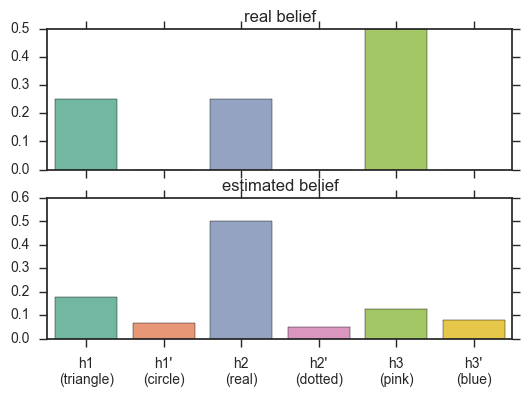

In [6]:
# visualize the estimated belief
f, (ax1, ax2) = plt.subplots(2, sharex=True);
sns.barplot(x="hypothesis", y="confidence", 
            data= {
                "hypothesis":hyps, 
                "confidence":rho}, 
            ax=ax1);
sns.barplot(x="hypothesis", y="confidence", 
            data= {
                "hypothesis":hyps, 
                "confidence":est_rho}, 
            ax=ax2);
ax1.set_title('real belief');
ax2.set_title('estimated belief');

In [7]:
# the expected label for a single instance
def expected_label(dist, x):
    hs = np.array(range(6))
    hxs = np.array(list(map(lambda h: hypothesis(x, h), hs)))
    return (dist * hxs).sum()

# the expected error over the dataset
def expected_error(expe_label):
    res = 0
    for i in xrange(2):
        for j in xrange(2):
            for k in xrange(2):
                res += np.abs(expe_label([i, j, k]) - hypothesis([i, j, k], 4))
    return res / 8

print "real error rate:\t", expected_error(lambda x: expected_label(rho, x))
print "estimated error rate:\t", expected_error(lambda x: expected_label(est_rho, x))

real error rate:	0.25
estimated error rate:	0.475994039637


---
### Round 1 - Teaching Phase

In [8]:
# First Round - Teaching Phase
o_t = []

# Ground Truth Set of Cardinality NG
NG = 6
X = np.random.choice(2, (NG, 3))
G = [(x, hypothesis(x, 4)) for x in X]

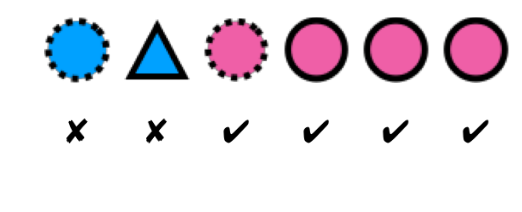

In [9]:
# Visualize the Ground Truth Set
def visualize(g):
    _, ax = plt.subplots(2, len(g), figsize=(len(g), 2));
    for i in xrange(len(g)):
        name = ""
        ansname = ""
        x, y = g[i]
        for j in xrange(3):
            name += str(x[j])
        ansname = str(y)
        img = mpimg.imread("imgs/"+ name +".png")
        ans = mpimg.imread("imgs/"+ ansname +".png")
        ax[0, i].imshow(img); ax[0, i].axis('off');
        ax[1, i].imshow(ans); ax[1, i].axis('off');    

visualize(G)

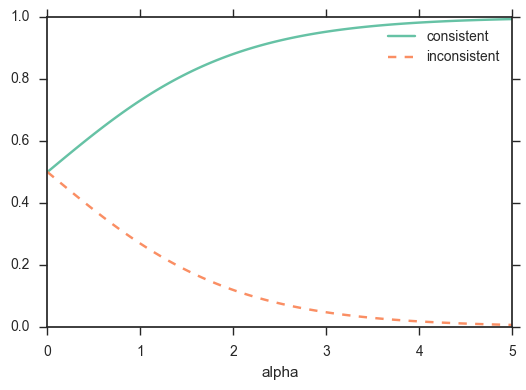

In [10]:
# Likelihood model gives p(label | hyp, x)
def likelihood(label, hyp, x, alpha):
    corr = 1 - 2 * np.abs(hyp(x) - label)
    return 1.0 / (1.0 + np.exp(-alpha * corr))

# Visualize the likelihood curve w.r.t alpha
alpha = np.linspace(0,5,100)
plt.plot(alpha, likelihood(0, lambda x: hypothesis(x, 1), [1,1,1], alpha), 
                   label='consistent');
plt.plot(alpha, likelihood(1, lambda x: hypothesis(x, 1), [1,1,1], alpha), 
                     label='inconsistent',linestyle='--');
plt.legend();
plt.xlabel('alpha');

In [11]:
alpha = 2
# cumulative likelihood over the observable set
def cumll(obs):
    if len(obs) == 0: return np.ones(6)
    lls = [list(map(lambda (x, y):
                    likelihood(y, lambda t: hypothesis(t, i), x, alpha), obs)) 
           for i in xrange(6)]
    for i in xrange(6):
        prod_ll = 1
        for ll in lls[i]:
            prod_ll *= ll
        lls[i] = prod_ll
    res = np.array(lls)
    return res

# bayesian update
def bs_update(ll, dist):
    return l1normalize(ll * dist)

#### Optimal Teaching
The "rational anticipant" should be $\displaystyle \rho_{\widehat\theta}(h|o_t) = \frac{\prod_{(x_i, c_i) \in \mathcal o_t} \sigma_{\alpha}(h(x_i),c_i)}{\sum_{h\in \mathcal H} \prod_{(x_i, c_i) \in \mathcal o_t} \sigma_{\alpha}(h(x_i),c_i)\rho_{\widehat\theta}(h)}\rho_{\widehat\theta}(h) $  

Our goal is to find optimal subset $o_t \subseteq \mathcal G$ such that the error $\displaystyle \mathbb E_{h\sim\rho_{\widehat\theta}(h|o_t)} \left[\sum_{(x_i,c_i)\in\mathcal G}|h(x_i) - c_i| \right]$ is minimized.

It is easy to see that  
$\begin{eqnarray}
\displaystyle \mathbb E_{h\sim\rho_{\widehat\theta}(h|o_t)} \left[\sum_{(x_i,c_i)\in\mathcal G}|h(x_i) - c_i| \right]
& = &\sum_{(x_i,c_i)\in\mathcal G} \left[ \frac{\sum_{h\in \mathcal H}  |h(x_i) - c_i| \cdot \rho_{\widehat\theta}(h)\cdot \prod_{(x_j, c_j) \in \mathcal o_t} \sigma_{\alpha}(h(x_j),c_j)}{\sum_{h\in \mathcal H} \prod_{(x_j, c_j) \in \mathcal o_t} \sigma_{\alpha}(h(x_j),c_j)\rho_{\widehat\theta}(h)} \right]
\end{eqnarray}$  

For any data $(x_i, c_i) \in \mathcal G$, if the estimated probability of choosing some wrong hypothesis $h$ such that $h(x_i)\neq c_i$ is high, then we would better to reduce it by add this counter-example to minimize the error. Then here comes an efficient algorithm (beam search).

```
# beam width = 1, greedy
for i = 0..M-1 do {
    f = cumll(examples) * ets_row
    score = {|f(x_i)-c_i|}, for all (x_i, c_i) in G
    examples[i] = (x_i, c_i) with highest score
}
return examples
```

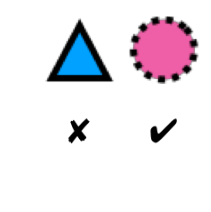

In [12]:
# # randomly pick M teaching examples
# o_t = list(map(lambda i: G[i], np.random.choice(NG, M, replace=False)))
# visualize(o_t)

# get new example for optimal teaching
def opt_examples(obs, dist):
    examples = []
    for i in xrange(M):
        new_dist = cumll(obs + examples) * dist
        scores = [np.abs(expected_label(new_dist, x) - y) for (x, y) in G]
        examples.append(G[np.argmax(scores)])
    return examples

o_t = []
newegs = opt_examples([], est_rho)
o_t = o_t + newegs
visualize(newegs)

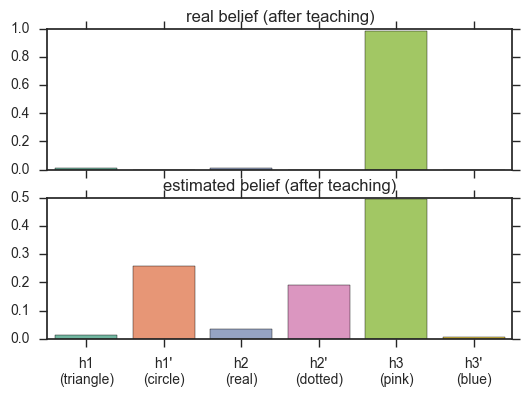

In [13]:
# visualize the real belief & estimated belief after some of the teaching set is revealed
f, (ax1, ax2) = plt.subplots(2, sharex=True);
sns.barplot(x="hypothesis", y="confidence", 
            data= {
                "hypothesis":hyps, 
                "confidence":bs_update(cumll(o_t), rho)}, 
            ax=ax1);
sns.barplot(x="hypothesis", y="confidence", 
            data= {
                "hypothesis":hyps, 
                "confidence":bs_update(cumll(o_t), est_rho)}, 
            ax=ax2);
ax1.set_title('real belief (after teaching)');
ax2.set_title('estimated belief (after teaching)');

-----------
### Round 2 - Test Phase

In [14]:
# if the learner bayesian update her belief
rho = bs_update(cumll(o_t), rho)

# Second Round - Test Phase
# Sample K instance from the dataset uniform randomly
questions = np.random.choice(2, (K, 3))
# Pick hypothesis and label the data according to current belief
actions = np.random.choice(range(6), size=K, p=rho)
answers = np.array([hypothesis(questions[i], actions[i]) for i in xrange(K)])

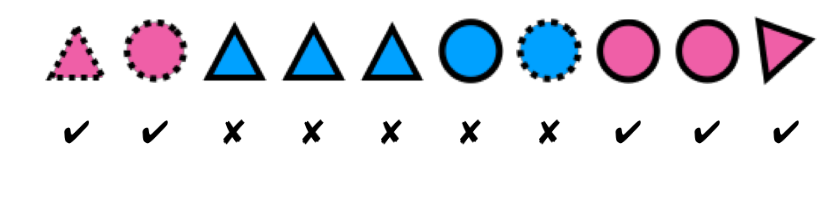

In [15]:
# Visualize the answers
_, ax = plt.subplots(2, K, figsize=(K, 2));
for i in xrange(K):
    name = ""
    ansname = ""
    for j in xrange(3):
        name += str(questions[i,j])
    ansname = str(answers[i])
    img = mpimg.imread("imgs/"+ name +".png")
    ans = mpimg.imread("imgs/"+ ansname +".png")
    ax[0, i].imshow(img); ax[0, i].axis('off');
    ax[1, i].imshow(ans); ax[1, i].axis('off');

In [16]:
# belief estimation
theta = np.zeros(6)
grad = np.ones(6)
est_rho = np.ones(6)

# estimate the belief via gradient decent
for iteration in xrange(1000): 
    old_est_rho = est_rho
    est_rho = np.exp(theta)
    partition = np.exp(theta).sum()
    est_rho = est_rho / partition
    log_est_rho = np.log(est_rho)

    # Estimate the gradient
    grad = np.zeros(6)
    for i in xrange(K):
        hs = np.array(range(6))
        hxs = np.array(list(map(lambda h: hypothesis(questions[i], h), hs)))
        grad += est_rho * (np.abs((hxs - answers[i]))+ (log_est_rho + 1)/K) * (np.ones(6) - est_rho)
    
    # update theta in rate 0.1
    theta -=  0.1 * grad
    # softmax trick to avoid overflow/underflow
    theta -= theta.min()

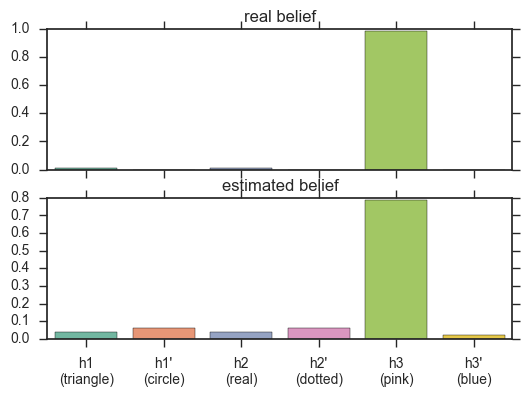

In [17]:
# visualize the estimated belief
f, (ax1, ax2) = plt.subplots(2, sharex=True);
sns.barplot(x="hypothesis", y="confidence", 
            data= {
                "hypothesis":hyps, 
                "confidence":rho}, 
            ax=ax1);
sns.barplot(x="hypothesis", y="confidence", 
            data= {
                "hypothesis":hyps, 
                "confidence":est_rho}, 
            ax=ax2);
ax1.set_title('real belief');
ax2.set_title('estimated belief');

In [18]:
# see the error
print "real error rate:\t", expected_error(lambda x: expected_label(rho, x))
print "estimated error rate:\t", expected_error(lambda x: expected_label(est_rho, x))

real error rate:	0.00899310498105
estimated error rate:	0.116043011928


-------
### Round 2 - Teaching Phase

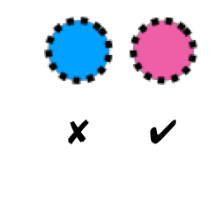

In [19]:
# give best M examples
newegs = opt_examples([], est_rho)
o_t = o_t + newegs
visualize(newegs)

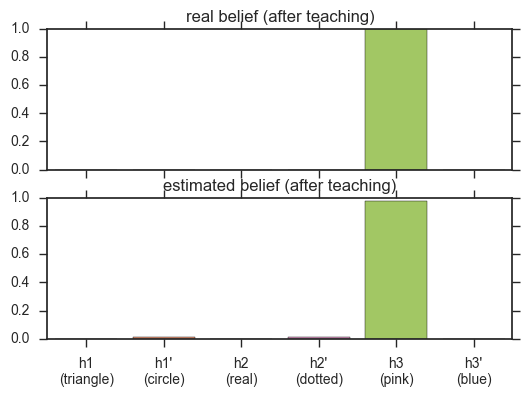

In [20]:
# visualize the real belief & estimated belief after some of the teaching set is revealed
f, (ax1, ax2) = plt.subplots(2, sharex=True);
sns.barplot(x="hypothesis", y="confidence", 
            data= {
                "hypothesis":hyps, 
                "confidence":bs_update(cumll(o_t), rho)}, 
            ax=ax1);
sns.barplot(x="hypothesis", y="confidence", 
            data= {
                "hypothesis":hyps, 
                "confidence":bs_update(cumll(o_t), est_rho)}, 
            ax=ax2);
ax1.set_title('real belief (after teaching)');
ax2.set_title('estimated belief (after teaching)');